# Lagrangian Coherent Structures - Finite-time coherent sets - method 01

Identifying a 'finite-time coherent set' from a set of particle trajectories using the 'adaptive transfer operator method' using eigenfunctions of the dynamic Laplace operator. (ADD References)

* Author(s): Michael Denes
* Created on: 28/06/23
* Last updated on:

In [1]:
import time

print(time.ctime(time.time()))

Wed Jun 28 16:20:50 2023


## 0.  Imports and package versions

In [2]:
%matplotlib inline
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import xarray as xr

from matplotlib import colors 
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from collections import namedtuple
from shapely import geometry

import scipy 
from scipy import stats, optimize, interpolate

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, cartopy, scipy

Software versions
Python 3.11.4 64bit [Clang 15.0.7 ]
IPython 8.14.0
OS macOS 13.4.1 arm64 arm 64bit
numpy 1.25.0
matplotlib 3.7.1
xarray 2023.6.0
cartopy 0.21.1
scipy 1.11.0
Wed Jun 28 16:20:52 2023 CEST

## 1. Loading the data

In [4]:
filedir = '../Simulations/'

In [5]:
ds = xr.open_dataset(filedir + 'toy_data_01.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

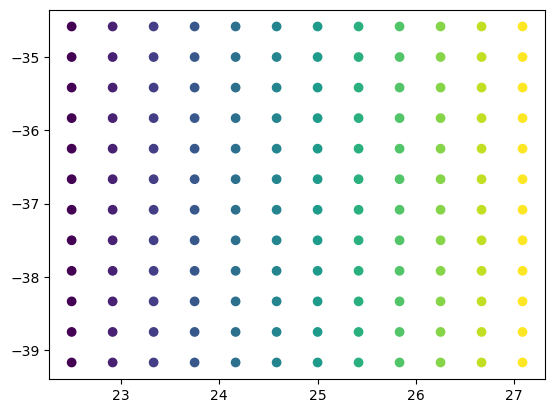

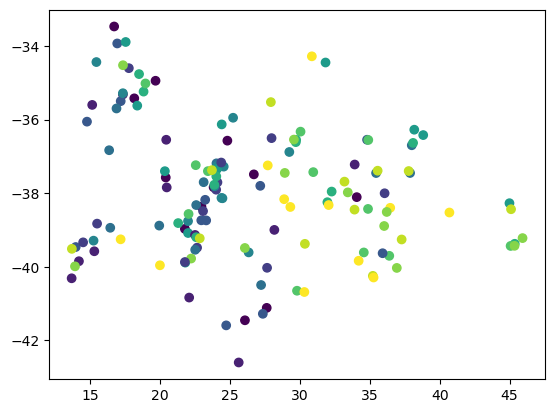

In [7]:
## Plot of particles at beginning and at end

plt.scatter(ds.lon.data[:,0], ds.lat.data[:,0], c= ds.lon.data[:,0])
plt.show()

plt.scatter(ds.lon.data[:,-1], ds.lat.data[:,-1], c=ds.lon.data[:,0])
plt.show()

In [8]:
## Compute FTCS over first 30 days

In [9]:
 import numpy as np
 import matplotlib.pyplot as plt
 import scipy as sp
 from scipy.spatial import Delaunay
 from scipy.sparse import csc_matrix
 from scipy.sparse.linalg import eigsh
 from matplotlib.tri import Triangulation

In [38]:
def gradbasis(particles,triangulation):

    v = np.empty((3,2,triangulation.shape[0]))
    v[0] = particles[:,triangulation[:,2]] - particles[:,triangulation[:,1]]
    v[1] = particles[:,triangulation[:,0]] - particles[:,triangulation[:,2]]
    v[2] = particles[:,triangulation[:,1]] - particles[:,triangulation[:,0]]

    area = 0.5*(-v[2,0,:]*v[1,1,:] + v[2,1,:]*v[1,0,:])

    dphi = np.empty((2,3,triangulation.shape[0]))
    dphi[0] = -v[:,1,:]/(2*area)
    dphi[1] = v[:,0,:]/(2*area)
    area = abs(area)

    return dphi, area

#From src/gradbasis.py
def spherical_gradbasis(particles_spherical,triangulation_spherical):

    # Create a congruent triangular element
    v = np.empty((3,2,triangulation_spherical.shape[0]))

    ab = particles_spherical[:,triangulation_spherical[:,1]] - particles_spherical[:,triangulation_spherical[:,0]]
    ac = particles_spherical[:,triangulation_spherical[:,2]] - particles_spherical[:,triangulation_spherical[:,0]]
    ab_norm = np.linalg.norm(ab, axis=0)
    ac_norm = np.linalg.norm(ac, axis=0)

    cosA = np.abs(np.sum(ab * ac, axis=0) / (ab_norm*ac_norm))
    sinA = np.abs(np.linalg.norm(np.cross(ab, ac, axis=0), axis=0) / (ab_norm*ac_norm))
    l1 = ab_norm
    l2 = ac_norm*cosA
    l3 = ac_norm*sinA

    ## Original triangle
    # A - 0th vertex
    # B - 1st vertex
    # C - 2nd vertex

    ## Congruent triangles
    # A (0,0)
    # B (l1,0) -> l1 = |AB|
    # C (l2 cos(A),l2 sin(A)) -> l2 = |AC|, A = angle(BAC)

    v[0,:,:] = [l2-l1,l3]
    v[1,:,:] = [-l2, -l3]
    v[2,:,:] = [l1, np.zeros(triangulation_spherical.shape[0])]

    #v[0,:,:] = [l1-l2,-l3]
    #v[1,:,:] = [-l1, np.zeros(triangulation_spherical.shape[0])]
    #v[2,:,:] = [l2, l3]

    # Compute area and gradients in \mathbb{R}^{2} of the congruent triangular element
    area = 0.5*(-v[2,0,:]*v[1,1,:] + v[2,1,:]*v[1,0,:])

    dphi = np.empty((2,3,triangulation_spherical.shape[0]))
    dphi[0] = -v[:,1,:]/(2*area)
    dphi[1] = v[:,0,:]/(2*area)
    area = abs(area)

    return dphi, area

#From src/assemble.py
def assemble(p,t,pb=None,G=None, spherical=False):

    nparticles = p.shape[1] ## Number of particles
    nt = t.shape[0] ## Number of elements

    if spherical == True:
        dphi, area = spherical_gradbasis(p,t)
    else:
        dphi, area = gradbasis(p,t)

    PG = np.transpose(G[:,:,:], (2,1,0))

    D = lil_matrix((nparticles, nparticles))
    M = lil_matrix((nparticles, nparticles))


    for i in range(3):
        for j in range(i,3):
            Dij = -area*(dphi[0,i,:] * PG[:,0,0] * dphi[0,j,:] +
                         dphi[0,i,:] * PG[:,0,1] * dphi[1,j,:] +
                         dphi[1,i,:] * PG[:,1,0] * dphi[0,j,:] +
                         dphi[1,i,:] * PG[:,1,1] * dphi[1,j,:])
            Mij = area/12.

            I = t[:,i]
            J = t[:,j]

            if (j == i):
                D = D + coo_matrix((Dij,(I,J)), shape=(nparticles,nparticles))
                M = M + coo_matrix((Mij + area/12.,(I,J)), shape=(nparticles,nparticles))
            else:
                D = D + coo_matrix((Dij,(I,J)), shape=(nparticles,nparticles))
                D = D + coo_matrix((Dij,(J,I)), shape=(nparticles,nparticles))

                M = M + coo_matrix((Mij,(I,J)), shape=(nparticles,nparticles))
                M = M + coo_matrix((Mij,(J,I)), shape=(nparticles,nparticles))

    return [D.tocsr(),M.tocsr()]

In [39]:
ds.traj.shape[0]

144

In [40]:
n = ds.traj.shape[0] # number of particles
nt = ds.obs.shape[0] # number of observations

#Delaunay options
options = 'Qt Qbb Qc'

t = [] #stores our Delaunay simplices

D = sp.sparse.csc_matrix((n, n))
M = sp.sparse.csc_matrix((n, n))

In [41]:
test = Delaunay(p.T, qhull_options=options)

In [42]:
test.simplices

array([[  1,   2,  84],
       [  2,   1,   3],
       [  2,  24,  84],
       [ 31,   7,   1],
       [ 45,  31,   1],
       [ 70,  44,  58],
       [ 95,  44,  70],
       [  7,  19,   1],
       [ 94,  19,   7],
       [ 19,  94,   4],
       [ 25,  13, 141],
       [ 43,  31,  45],
       [ 59,  45,  58],
       [ 44,  59,  58],
       [ 59,  44,  45],
       [ 23,   9,   8],
       [  8,   9,  14],
       [ 80, 131, 140],
       [131, 119, 140],
       [ 71,  94,  70],
       [ 94,  71,   4],
       [ 17,  28,  29],
       [  6,  94,   7],
       [  6,  95,  70],
       [ 94,   6,  70],
       [  1,  46,   3],
       [ 19,  46,   1],
       [101, 141, 110],
       [101,  25, 141],
       [ 36, 111,  97],
       [ 36, 143,  13],
       [139, 125, 140],
       [125,  80, 140],
       [127, 125, 139],
       [125, 127, 124],
       [ 18,  43,  95],
       [ 43,  18,  31],
       [ 44,  57,  45],
       [ 57,  43,  45],
       [ 57,  44,  95],
       [ 43,  57,  95],
       [ 11,   9

In [43]:
p.shape

(2, 144)

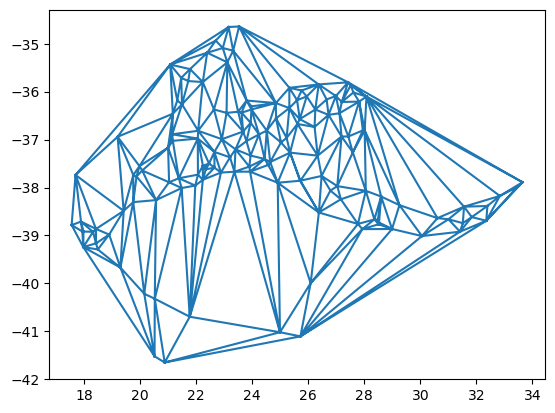

In [44]:
plt.triplot(p[0,:], p[1,:], test.simplices)
plt.show()

In [45]:



pb = np.array([np.arange(0,np.square(n)), np.arange(0,np.square(n))])
for k in range(0,30):#nt):
    p = np.asarray([ds.lon.data[:,k],ds.lat.data[:,k]])
    t.insert(k, Delaunay(p.T, qhull_options=options).simplices)

    # Want to remove simplices with zero volume
    keep = np.ones(len(t[k]), dtype = bool)
    for i, z in enumerate(t[k]):
        if abs(np.linalg.det(np.hstack((np.transpose(p)[z], np.ones([1,3]).T)))) < 1E-15:
            keep[i] = False # Point is coplanar, we don't want to keep it
    t[k] = t[k][keep]

    A = np.kron([1, 0, 1], np.ones((len(t[k]),1)))
    G = np.tile(np.eye(2)[:,:,np.newaxis],[1,1,t[k].shape[0]])
    [Dt, Mt] = assemble(p, t[k], pb, G)#A)

    D = D + Dt
    M = M + Mt

In [46]:
L,V = eigsh(D, 10, M, sigma=0, which='LM')

pos = (-L).argsort()
lam = L[pos]
ord = V[:,pos]

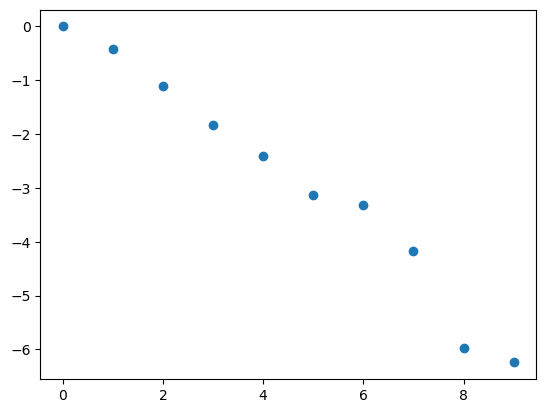

In [47]:
plt.scatter(np.arange(len(lam)), lam)
plt.show()

In [48]:
from matplotlib.tri import Triangulation

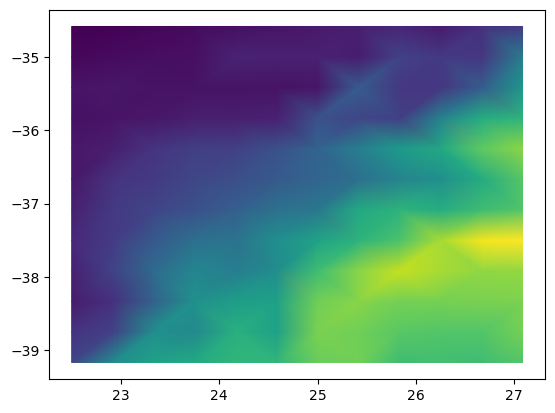

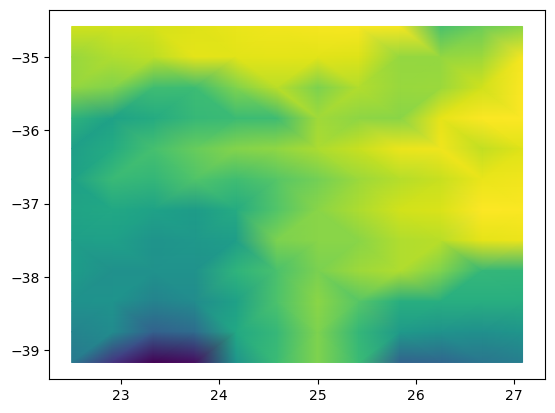

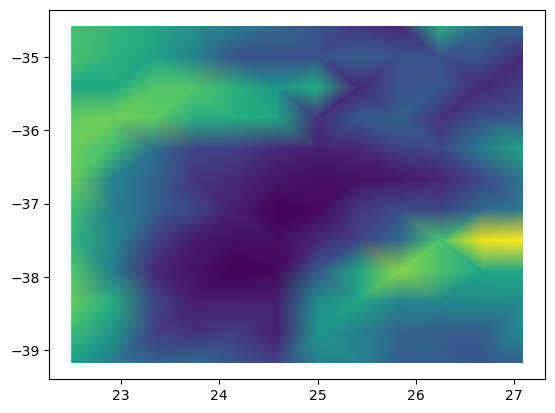

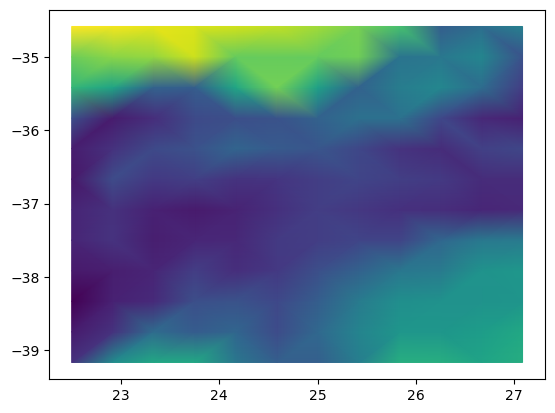

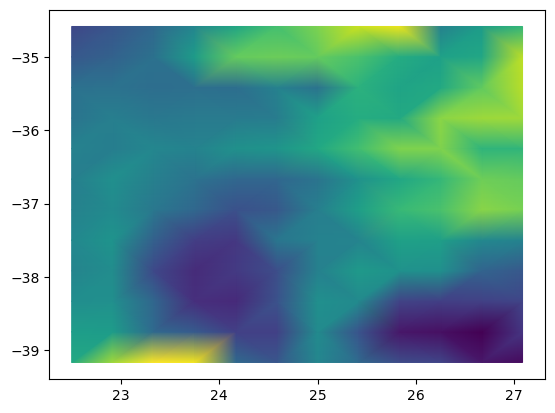

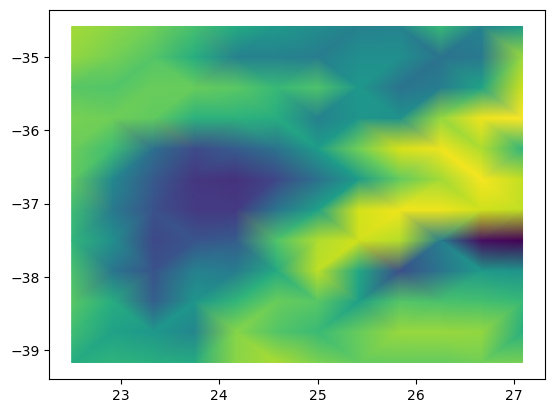

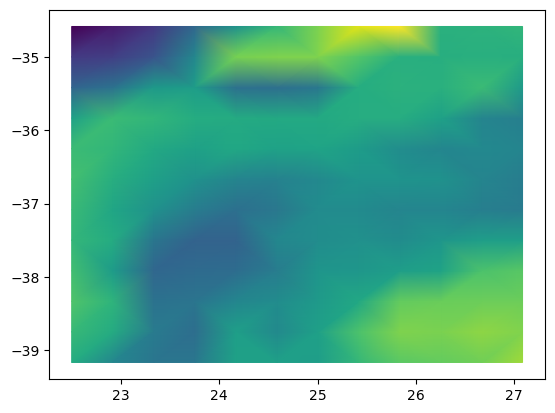

In [50]:
for i in range(1,8):
    plt.tripcolor(Triangulation(ds.lon.data[:,0], ds.lat.data[:,0], t[0]), ord[:,i], shading='gouraud')
    plt.show()

In [29]:
ord.shape

(144, 10)